In [1]:
import datetime
import email
import imaplib
import mailbox
from datetime import datetime, timedelta
import pandas as pd
import numpy as np
import re
import glob
from geopandas.tools import sjoin
from numpy import nansum
from numpy import nanmean
import datetime
import functools
from datetime import datetime
import geopandas as gpd
from pandas import DataFrame
from shapely.geometry import Point
from shapely import geometry
import matplotlib.pyplot as plt

In [2]:
from functools import partial

import pyproj
from shapely import geometry
from shapely.geometry import Point
from shapely.ops import transform



In [3]:
## Define functions for calculating wet bulb temperature and clean data
import math
from scipy.optimize import brentq
Gamma=0.66

#----------------numerical solution--------------------------
# Tw + (es*(Tw))/𝛾 = Ta + ea/ 𝛾
# Ta air temperature 
# RH relative humidit
def TwNumerical(Ta,RH):
    SaturatedVPTa = 6.11* np.exp( (17.269*Ta) / (237.3+Ta) )
    VaporPressure = SaturatedVPTa*RH/100.0    
    def GetRoot(Tw):
        SaturatedVPTw = 6.11* np.exp( (17.269*Tw) / (237.3+Tw) )
        Function = Tw + SaturatedVPTw/Gamma-Ta-VaporPressure/Gamma
        return Function
    root,info = brentq(GetRoot,-20,50, full_output=True)
    return root


#----------------stull's formula----------------------
# use Stull's formula to calculate wet bulb temperature
# Ta air temperature 
# RH relative humidity
def Tw_Stull(Ta, RH):
    Tw_Stull=Ta*np.arctan(0.151977*(RH+8.313659)**0.5)+\
            np.arctan(Ta+RH)-np.arctan(RH-1.676331)+\
            np.arctan(0.023101*RH)*0.00391838*RH**(3./2.)-4.686035
    return Tw_Stull

def Clean_table_TW(df, st, tr):

    df['Lon'] = df['Lon'].str.replace('W','-').str.replace('E','').str.replace(' ','').astype(float)
    df['Lat'] = df['Lat'].str.replace('S','-').str.replace('N','').str.replace(' ','').astype(float)
    df['Temp'] = df['Temp'].str.replace('C','').str.replace(' ','').astype(float)
    df['Temp']=(df['Temp']-32)*5/9
    df['RH'] = df['RH'].str.replace('%','').str.replace(' ','').astype(float)
    df['Time']= pd.to_datetime(st[4:6]+'-'+st[-2:]+'-'+st[0:4]+ ' ' + df['Time'])
    #df['Biked']=np.nan
    #df['Biked'][0]=(df['Time'][df.shape[0]-1]-df['Time'][0]).seconds/60
    #df['Date']=np.nan
    #df['Date'][0]=str('Trip '+tr+' ('+st[4:6]+'-'+st[-2:]+'-'+st[0:4]+')')
    #df['Date_all']=str('Trip '+tr+' ('+st[4:6]+'-'+st[-2:]+'-'+st[0:4]+')')
    #df['Time']=df['Time'].replace(year=int(st[0:4]), month=int(st[4:6]), day=int(st[-2:]))
    df['Tw_Numerical']=df.apply(lambda x: TwNumerical(x['Temp'], x['RH']), axis=1)
    df['Tw_Stull']=Tw_Stull(df['Temp'], df['RH'])
    
    
    
    
    df = df.fillna('')
    return df

In [4]:
#Load in list of data
Dat_list=glob.glob('Bike study-6/*.txt')
Dat_list

['Bike study-6\\20191002-evening.txt',
 'Bike study-6\\20191002-morning.txt',
 'Bike study-6\\20191003-evening.txt',
 'Bike study-6\\20191003-morning.txt',
 'Bike study-6\\20191004-evening.txt',
 'Bike study-6\\20191004-morning.txt',
 'Bike study-6\\20191022-evening.txt',
 'Bike study-6\\20191022-morning.txt',
 'Bike study-6\\20191023-evening.txt',
 'Bike study-6\\20191023-morning.txt',
 'Bike study-6\\20191025-evening.txt',
 'Bike study-6\\20191025-morning.txt',
 'Bike study-6\\20191028-evening.txt',
 'Bike study-6\\20191028-morning.txt',
 'Bike study-6\\20191029-evening.txt',
 'Bike study-6\\20191029-morning.txt',
 'Bike study-6\\20191030-evening.txt',
 'Bike study-6\\20191030-morning.txt',
 'Bike study-6\\20191031-evening.txt',
 'Bike study-6\\20191031-morning .txt',
 'Bike study-6\\20191115.txt',
 'Bike study-6\\20191118.txt',
 'Bike study-6\\20191120-morning.txt',
 'Bike study-6\\20191120.txt',
 'Bike study-6\\20191122.txt',
 'Bike study-6\\20191125.txt',
 'Bike study-6\\20200224e

In [5]:

# Read csvs and clean data
Dat_all=[]
ii=1
for item in Dat_list:
    Dat=pd.read_csv(item, names=["Time", "Lon", "Lat", "ID","Temp","RH"]) 
    Dat_clean=Clean_table_TW(Dat, str(item)[13:21], "{:0>2}".format(str(ii)))
    #Start=Point(Dat_clean.Lon[0], Dat_clean.Lat[0])
    #Start=Point(-72.923676,41.316836)
    #Start_transformed = transform(wgs84_to_aeqd, Start)
    #Start_buffer = Start_transformed.buffer(radius)
    # Get the polygon with lat lon coordinates
    #Start_buff = transform(aeqd_to_wgs84, Start_buffer)
    #Start_buff=geodesic_point_buffer(Dat_clean.Lon[0], Dat_clean.Lat[0], 50)
    #End=Point(Dat_clean.iloc[len(Dat_clean)-1].Lon, Dat_clean.iloc[len(Dat_clean)-1].Lat)
    #End=Point(-72.902316, 41.357839)
    #End_transformed = transform(wgs84_to_aeqd, End)
    #End_buffer = End_transformed.buffer(radius)
    # Get the polygon with lat lon coordinates
    #End_buff = transform(aeqd_to_wgs84, End_buffer)
    #Dat_clean = gpd.GeoDataFrame(Dat_clean, crs= {'EPSG:4326'}, geometry=gpd.points_from_xy(Dat_clean.Lon, Dat_clean.Lat))
    #df = pd.DataFrame({'Case': ['Start','End']})
    #Loc_frame = gpd.GeoDataFrame(df, crs= {'EPSG:4326'}, geometry = [Start_buff,End_buff])
    #Dat_clean = sjoin(Dat_clean, Loc_frame, how='left') 
    #End_buff=geodesic_point_buffer(Dat_clean.iloc[len(Dat_clean)-1].Lon, Dat_clean.iloc[len(Dat_clean)-1].Lat, 50)
    #Dat_clean=Dat_clean[Dat_clean['Case']!='Start']
    #Dat_clean=Dat_clean[Dat_clean['Case']!='End']
    Dat_all.append(Dat_clean)
    ii=ii+1


In [6]:
# Dat_clean = gpd.GeoDataFrame(Dat_clean, crs= {'EPSG:4326'}, geometry=gpd.points_from_xy( Dat_clean.Lon, Dat_clean.Lat))
# df = pd.DataFrame({'Case': ['Start','End']})
# Loc_frame = gpd.GeoDataFrame(df, crs= {'EPSG:4326'}, geometry = [Start_buff,End_buff])
# Loc_frame
# Dat_clean = sjoin(Dat_clean, Loc_frame, how='left') 
# Dat_clean
Dat_clean

,Time,Lon,Lat,ID,Temp,RH,Tw_Numerical,Tw_Stull
0,2020-03-12 08:47:55,-72.90195,41.35826,AFF9,10.261111,47.05,5.490998,5.052584
1,2020-03-12 08:47:56,-72.90195,41.35826,AFF9,10.261111,47.15,5.500703,5.061838
2,2020-03-12 08:47:57,-72.90159,41.35837,AFF9,10.238889,47.14,5.481548,5.042081
3,2020-03-12 08:47:58,-72.90200,41.35811,AFF9,10.261111,47.19,5.504585,5.065540
4,2020-03-12 08:47:59,-72.90206,41.35805,AFF9,10.272222,47.17,5.511737,5.073106
...,...,...,...,...,...,...,...,...
1617,2020-03-12 09:16:54,-72.92315,41.31662,AFF9,17.900000,53.31,12.501311,12.304962
1618,2020-03-12 09:16:55,-72.92315,41.31662,AFF9,17.900000,53.41,12.514033,12.317307
1619,2020-03-12 09:16:56,-72.92315,41.31662,AFF9,17.922222,53.56,12.551713,12.355246
1620,2020-03-12 09:16:58,-72.92315,41.31662,AFF9,17.911111,53.58,12.544953,12.347999


In [7]:
# Dat_all_trimmed=[]
# for item in Dat_all:
#     Temp=item.iloc[240:]
#     Temp=Temp[:-240]
#     Dat_all_trimmed.append(Temp)

In [8]:
#Dat_all_trimmed

In [9]:
#Concatanate into one data frame
result= pd.concat(Dat_all, ignore_index=True)
result
##Remove duplicate datetimes
result=result.drop_duplicates(subset=['Time']).sort_values(['Time']).reset_index()
#result=result.drop(columns=['index_right', 'Case','geometry'])
result

,index,Time,Lon,Lat,ID,Temp,RH,Tw_Numerical,Tw_Stull
0,0,2019-10-02 08:08:12,-72.90217,41.35806,AFF9,23.500000,79.62,20.923797,20.838650
1,1,2019-10-02 08:08:13,-72.90217,41.35806,AFF9,23.527778,79.54,20.939260,20.854587
2,2,2019-10-02 08:08:14,-72.90216,41.35806,AFF9,23.527778,79.46,20.928626,20.843884
3,3,2019-10-02 08:08:15,-72.90216,41.35806,AFF9,23.500000,79.38,20.891918,20.806557
4,4,2019-10-02 08:08:16,-72.90217,41.35805,AFF9,23.527778,79.34,20.912667,20.827826
...,...,...,...,...,...,...,...,...,...
112548,143666,2020-03-12 13:44:27,-72.90227,41.35798,AFF9,9.200000,60.01,5.803058,5.305589
112549,143667,2020-03-12 13:44:28,-72.90227,41.35798,AFF9,9.172222,59.87,5.766360,5.268015
112550,143668,2020-03-12 13:44:30,-72.90227,41.35798,AFF9,9.177778,59.72,5.757764,5.259496
112551,143669,2020-03-12 13:44:33,-72.90229,41.35799,AFF9,9.177778,59.60,5.747017,5.248692


In [10]:
## Add Biked and Date column
result['Date']=np.nan
result['Date_all']=np.nan
result['Biked']=np.nan
kk=0
for index, row in result.iterrows():
    result['Date_all'][index]=str(result['Time'][kk])  
    if (index<=len(result)-2):
        if(((result['Time'][index+1]-result['Time'][index]).seconds>=300)):
            result['Biked'][kk]=(result['Time'][index]-result['Time'][kk]).seconds/60
            result['Date'][kk]=str(result['Time'][kk])
            result['Date_all'][index]=str(result['Time'][kk])
            kk=index+1
    else:
        result['Biked'][kk]=(result['Time'][index]-result['Time'][kk]).seconds/60
        result['Date'][kk]=str(result['Time'][kk])
        result['Date_all'][index]=str(result['Time'][kk])
        kk=index+1
        #result['Biked'][index]=np.nan
        #result['Date'][index]=np.nan
#     if (index==0):
#         #result['Biked'][index]=np.nan
#         #result['Date'][index]=np.nan
#         result['Date_all'][index]=str(result['Time'][index])
#         result['Date'][index]=str(result['Time'][index])
#         result['Biked'][index]=(result['Time'][kk]-result['Time'][index]).seconds/60

C:\Users\tirth\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
C:\Users\tirth\Anaconda3\lib\site-packages\pandas\core\indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)
C:\Users\tirth\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while w

In [11]:
#Fin=result[(result['Biked']<=240) | (result['Biked']).isnull()]
#Remove cases where someone biked for 0 time
Fin=result[(result['Biked']>=5) | (result['Biked']).isnull()]
Fin=Fin[['Time', 'Lon', 'Lat', 'ID', 'Temp', 'RH', 'Biked','Date','Date_all','Tw_Numerical','Tw_Stull']]
Fin
Fin_grouped=Fin.groupby('Date_all')

In [12]:
## Remove data around starting and ending point
Fin_all=[]
radius=150
for g, item in Fin_grouped:
    item=pd.DataFrame(item).reset_index()
    Start=Point(item.Lon[0], item.Lat[0])
    local_azimuthal_projection = "+proj=aeqd +R=6371000 +units=m +lat_0={} +lon_0={}".format(
    item.Lat[0], item.Lon[0])
    wgs84_to_aeqd = partial(pyproj.transform, pyproj.Proj("+proj=longlat +datum=WGS84 +no_defs"),pyproj.Proj(local_azimuthal_projection),)
    aeqd_to_wgs84 = partial(pyproj.transform, pyproj.Proj(local_azimuthal_projection), pyproj.Proj("+proj=longlat +datum=WGS84 +no_defs"),)
    Start_transformed = transform(wgs84_to_aeqd, Start)
    Start_buffer = Start_transformed.buffer(radius)
    #Get the polygon with lat lon coordinates
    Start_buff = transform(aeqd_to_wgs84, Start_buffer)
    End=Point(item.iloc[len(item)-1].Lon, item.iloc[len(item)-1].Lat)
    local_azimuthal_projection = "+proj=aeqd +R=6371000 +units=m +lat_0={} +lon_0={}".format(
    item.iloc[len(item)-1].Lat, item.iloc[len(item)-1].Lon)
    wgs84_to_aeqd = partial(pyproj.transform, pyproj.Proj("+proj=longlat +datum=WGS84 +no_defs"),pyproj.Proj(local_azimuthal_projection),)
    aeqd_to_wgs84 = partial(pyproj.transform, pyproj.Proj(local_azimuthal_projection), pyproj.Proj("+proj=longlat +datum=WGS84 +no_defs"),)
    End_transformed = transform(wgs84_to_aeqd, End)
    End_buffer = End_transformed.buffer(radius)
    #Get the polygon with lat lon coordinates
    End_buff = transform(aeqd_to_wgs84, End_buffer)
    item = gpd.GeoDataFrame(item, crs= {'EPSG:4326'}, geometry=gpd.points_from_xy(item.Lon, item.Lat))
    df = pd.DataFrame({'Case': ['Start','End']})
    Loc_frame = gpd.GeoDataFrame(df, crs= {'EPSG:4326'}, geometry = [Start_buff,End_buff])
    Dat_clean = sjoin(item, Loc_frame, how='left') 
    Dat_clean=Dat_clean[Dat_clean['Case']!='Start']
    Dat_clean=Dat_clean[Dat_clean['Case']!='End']
    Dat_reset=pd.DataFrame(Dat_clean).reset_index()
    if Dat_reset.shape[0]>0:
        Dat_reset['Date'][0]=Dat_reset['Date_all'][0]
        Dat_reset['Biked'][0]=(Dat_reset['Time'][Dat_reset.shape[0]-1]-Dat_reset['Time'][0]).seconds/60
    else:
        Dat_reset['Date']=np.nan
        Dat_reset['Biked']=0
    Fin_all.append(Dat_reset)

C:\Users\tirth\Anaconda3\lib\site-packages\ipykernel_launcher.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\tirth\Anaconda3\lib\site-packages\ipykernel_launcher.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\tirth\Anaconda3\lib\site-packages\ipykernel_launcher.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\tirth\Anaconda3\lib\site-packages\ipykernel_launcher.py:32: SettingWithCopyWarning: 
A valu

C:\Users\tirth\Anaconda3\lib\site-packages\ipykernel_launcher.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\tirth\Anaconda3\lib\site-packages\ipykernel_launcher.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\tirth\Anaconda3\lib\site-packages\ipykernel_launcher.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\tirth\Anaconda3\lib\site-packages\ipykernel_launcher.py:32: SettingWithCopyWarning: 
A valu

C:\Users\tirth\Anaconda3\lib\site-packages\ipykernel_launcher.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\tirth\Anaconda3\lib\site-packages\ipykernel_launcher.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\tirth\Anaconda3\lib\site-packages\ipykernel_launcher.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\tirth\Anaconda3\lib\site-packages\ipykernel_launcher.py:32: SettingWithCopyWarning: 
A valu

C:\Users\tirth\Anaconda3\lib\site-packages\ipykernel_launcher.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\tirth\Anaconda3\lib\site-packages\ipykernel_launcher.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\tirth\Anaconda3\lib\site-packages\ipykernel_launcher.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\tirth\Anaconda3\lib\site-packages\ipykernel_launcher.py:32: SettingWithCopyWarning: 
A valu

In [13]:
Dat_clean

,index,Time,Lon,Lat,ID,Temp,RH,Biked,Date,Date_all,Tw_Numerical,Tw_Stull,geometry,index_right,Case
139,111338,2020-03-12 13:23:21,-72.92270,41.31581,AFF9,9.127778,60.53,NaN,NaN,2020-03-12 13:20:58,5.786603,5.287482,POINT (-72.92270 41.31581),NaN,NaN
140,111339,2020-03-12 13:23:22,-72.92263,41.31580,AFF9,9.088889,60.72,NaN,NaN,2020-03-12 13:20:58,5.769592,5.269550,POINT (-72.92263 41.31580),NaN,NaN
141,111340,2020-03-12 13:23:24,-72.92247,41.31577,AFF9,9.172222,60.83,NaN,NaN,2020-03-12 13:20:58,5.852153,5.354580,POINT (-72.92247 41.31577),NaN,NaN
142,111341,2020-03-12 13:23:25,-72.92237,41.31575,AFF9,9.211111,60.94,NaN,NaN,2020-03-12 13:20:58,5.895944,5.399589,POINT (-72.92237 41.31575),NaN,NaN
143,111342,2020-03-12 13:23:26,-72.92228,41.31573,AFF9,9.327778,61.22,NaN,NaN,2020-03-12 13:20:58,6.022990,5.530268,POINT (-72.92228 41.31573),NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1236,112435,2020-03-12 13:42:30,-72.90243,41.35636,AFF9,8.627778,60.63,NaN,NaN,2020-03-12 13:20:58,5.359070,4.846049,POINT (-72.90243 41.35636),NaN,NaN
1237,112436,2020-03-12 13:42:31,-72.90241,41.35644,AFF9,8.622222,60.65,NaN,NaN,2020-03-12 13:20:58,5.355965,4.842810,POINT (-72.90241 41.35644),NaN,NaN
1238,112437,2020-03-12 13:42:32,-72.90239,41.35651,AFF9,8.627778,60.68,NaN,NaN,2020-03-12 13:20:58,5.363436,4.850465,POINT (-72.90239 41.35651),NaN,NaN
1239,112438,2020-03-12 13:42:33,-72.90238,41.35657,AFF9,8.672222,60.79,NaN,NaN,2020-03-12 13:20:58,5.411871,4.900247,POINT (-72.90238 41.35657),NaN,NaN


In [14]:
Fin= pd.concat(Fin_all, ignore_index=True)
##Remove duplicate datetimes
Fin=Fin.drop_duplicates(subset=['Time']).sort_values(['Time'])
Fin=Fin.drop(columns=['level_0','index_right', 'Case','geometry']).reset_index()
Fin=Fin[(Fin['Biked']>=5) | (Fin['Biked']).isnull()]
Fin=Fin[['index', 'Time', 'Lon', 'Lat', 'ID', 'Temp', 'RH', 'Biked',
       'Date', 'Date_all', 'Tw_Numerical', 'Tw_Stull']]


In [15]:
## Normalize data
Fin['Temp_norm'] = Fin.groupby('Date_all')['Temp'].apply(lambda x: (x-x.min())/(x.max()-x.min()))
#Fin['Temp_norm'] = Fin['Temp']-Fin['Temp_norm']
Fin['RH_norm'] = Fin.groupby('Date_all')['RH'].apply(lambda x: (x-x.min())/(x.max()-x.min()))
#Fin['RH_norm'] = Fin['RH']-Fin['RH_norm']
Fin['Tw_Numerical_norm'] = Fin.groupby('Date_all')['Tw_Numerical'].apply(lambda x: (x-x.min())/(x.max()-x.min()))
#Fin['Tw_Numerical_norm'] = Fin['Tw_Numerical']-Fin['Tw_Numerical_norm']
Fin

,index,Time,Lon,Lat,ID,Temp,RH,Biked,Date,Date_all,Tw_Numerical,Tw_Stull,Temp_norm,RH_norm,Tw_Numerical_norm
0,796,2019-10-02 08:22:13,-72.90382,41.35860,AFF9,22.188889,86.69,23.033333,2019-10-02 08:08:12,2019-10-02 08:08:12,20.585241,20.498236,0.386574,0.552306,0.368467
1,797,2019-10-02 08:22:14,-72.90392,41.35862,AFF9,22.188889,86.66,NaN,NaN,2019-10-02 08:08:12,20.581516,20.494357,0.386574,0.548931,0.365976
2,798,2019-10-02 08:22:16,-72.90411,41.35866,AFF9,22.188889,86.64,NaN,NaN,2019-10-02 08:08:12,20.579032,20.491771,0.386574,0.546682,0.364315
3,799,2019-10-02 08:22:17,-72.90416,41.35867,AFF9,22.188889,86.56,NaN,NaN,2019-10-02 08:08:12,20.569093,20.481426,0.386574,0.537683,0.357670
4,800,2019-10-02 08:22:18,-72.90424,41.35869,AFF9,22.222222,86.55,NaN,NaN,2019-10-02 08:08:12,20.599888,20.512691,0.400463,0.536558,0.378260
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
55752,112435,2020-03-12 13:42:30,-72.90243,41.35636,AFF9,8.627778,60.63,NaN,NaN,2020-03-12 13:20:58,5.359070,4.846049,0.018868,0.493225,0.002057
55753,112436,2020-03-12 13:42:31,-72.90241,41.35644,AFF9,8.622222,60.65,NaN,NaN,2020-03-12 13:20:58,5.355965,4.842810,0.016173,0.495935,0.000000
55754,112437,2020-03-12 13:42:32,-72.90239,41.35651,AFF9,8.627778,60.68,NaN,NaN,2020-03-12 13:20:58,5.363436,4.850465,0.018868,0.500000,0.004949
55755,112438,2020-03-12 13:42:33,-72.90238,41.35657,AFF9,8.672222,60.79,NaN,NaN,2020-03-12 13:20:58,5.411871,4.900247,0.040431,0.514905,0.037037


In [16]:
Fin_grouped=Fin.groupby('Date_all')

In [17]:
##Moving averaging
Fin_all=[]
for g, item in Fin_grouped:
    item=pd.DataFrame(item).reset_index()
    item['Temp_norm'] = item['Temp_norm'].rolling(120,min_periods=1,center=True).mean()
    item['RH_norm'] = item['RH_norm'].rolling(120,min_periods=1,center=True).mean()
    item['Tw_Numerical_norm'] = item['Tw_Numerical_norm'].rolling(120,min_periods=1,center=True).mean()
    Fin_all.append(item)

In [18]:
Fin= pd.concat(Fin_all, ignore_index=True)
Fin

,level_0,index,Time,Lon,Lat,ID,Temp,RH,Biked,Date,Date_all,Tw_Numerical,Tw_Stull,Temp_norm,RH_norm,Tw_Numerical_norm
0,0,796,2019-10-02 08:22:13,-72.90382,41.35860,AFF9,22.188889,86.69,23.033333,2019-10-02 08:08:12,2019-10-02 08:08:12,20.585241,20.498236,0.396412,0.543945,0.377437
1,1,797,2019-10-02 08:22:14,-72.90392,41.35862,AFF9,22.188889,86.66,NaN,NaN,2019-10-02 08:08:12,20.581516,20.494357,0.395909,0.544782,0.377279
2,2,798,2019-10-02 08:22:16,-72.90411,41.35866,AFF9,22.188889,86.64,NaN,NaN,2019-10-02 08:08:12,20.579032,20.491771,0.395572,0.545430,0.377237
3,3,799,2019-10-02 08:22:17,-72.90416,41.35867,AFF9,22.188889,86.56,NaN,NaN,2019-10-02 08:08:12,20.569093,20.481426,0.395245,0.545967,0.377130
4,4,800,2019-10-02 08:22:18,-72.90424,41.35869,AFF9,22.222222,86.55,NaN,NaN,2019-10-02 08:08:12,20.599888,20.512691,0.395110,0.546418,0.377254
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
55751,55752,112435,2020-03-12 13:42:30,-72.90243,41.35636,AFF9,8.627778,60.63,NaN,NaN,2020-03-12 13:20:58,5.359070,4.846049,0.093883,0.581030,0.129198
55752,55753,112436,2020-03-12 13:42:31,-72.90241,41.35644,AFF9,8.622222,60.65,NaN,NaN,2020-03-12 13:20:58,5.355965,4.842810,0.093287,0.580475,0.128246
55753,55754,112437,2020-03-12 13:42:32,-72.90239,41.35651,AFF9,8.627778,60.68,NaN,NaN,2020-03-12 13:20:58,5.363436,4.850465,0.093142,0.579967,0.127855
55754,55755,112438,2020-03-12 13:42:33,-72.90238,41.35657,AFF9,8.672222,60.79,NaN,NaN,2020-03-12 13:20:58,5.411871,4.900247,0.092775,0.579443,0.127192


In [19]:
# Fin['Temp_norm'][Fin['Temp_norm'] > 0.95] = np.nan
# Fin['Temp_norm'][Fin['Temp_norm'] < 0.05] = np.nan
# Fin['RH_norm'][Fin['RH_norm'] > 0.95] = np.nan
# Fin['RH_norm'][Fin['RH_norm'] < 0.05] = np.nan
# Fin['Tw_Numerical_norm'][Fin['Tw_Numerical_norm'] > 0.95] = np.nan
# Fin['Tw_Numerical_norm'][Fin['Tw_Numerical_norm'] < 0.05] = np.nan

In [20]:
# Fin['Temp_norm'] = Fin.groupby('Date_all')['Temp'].apply(lambda x: (x-x.min())/(x.max()-x.min()))
# #Fin['Temp_norm'] = Fin['Temp']-Fin['Temp_norm']
# Fin['RH_norm'] = Fin.groupby('Date_all')['RH'].apply(lambda x: (x-x.min())/(x.max()-x.min()))
# #Fin['RH_norm'] = Fin['RH']-Fin['RH_norm']
# Fin['Tw_Numerical_norm'] = Fin.groupby('Date_all')['Tw_Numerical'].apply(lambda x: (x-x.min())/(x.max()-x.min()))
# #Fin['Tw_Numerical_norm'] = Fin['Tw_Numerical']-Fin['Tw_Numerical_norm']
# Fin

In [21]:
##Keep only 10th data point
Temp_ind = Fin.groupby('Date_all')['Temp_norm'].cumcount() % 9
RH_ind = Fin.groupby('Date_all')['RH_norm'].cumcount() % 9
Tw_ind = Fin.groupby('Date_all')['Tw_Numerical_norm'].cumcount() % 9
Fin['Temp_norm'][Temp_ind != 0]=np.nan
Fin['RH_norm'][RH_ind != 0]=np.nan
Fin['Tw_Numerical_norm'][Tw_ind != 0]=np.nan
Fin

C:\Users\tirth\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
C:\Users\tirth\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
C:\Users\tirth\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,level_0,index,Time,Lon,Lat,ID,Temp,RH,Biked,Date,Date_all,Tw_Numerical,Tw_Stull,Temp_norm,RH_norm,Tw_Numerical_norm
0,0,796,2019-10-02 08:22:13,-72.90382,41.35860,AFF9,22.188889,86.69,23.033333,2019-10-02 08:08:12,2019-10-02 08:08:12,20.585241,20.498236,0.396412,0.543945,0.377437
1,1,797,2019-10-02 08:22:14,-72.90392,41.35862,AFF9,22.188889,86.66,NaN,NaN,2019-10-02 08:08:12,20.581516,20.494357,NaN,NaN,NaN
2,2,798,2019-10-02 08:22:16,-72.90411,41.35866,AFF9,22.188889,86.64,NaN,NaN,2019-10-02 08:08:12,20.579032,20.491771,NaN,NaN,NaN
3,3,799,2019-10-02 08:22:17,-72.90416,41.35867,AFF9,22.188889,86.56,NaN,NaN,2019-10-02 08:08:12,20.569093,20.481426,NaN,NaN,NaN
4,4,800,2019-10-02 08:22:18,-72.90424,41.35869,AFF9,22.222222,86.55,NaN,NaN,2019-10-02 08:08:12,20.599888,20.512691,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
55751,55752,112435,2020-03-12 13:42:30,-72.90243,41.35636,AFF9,8.627778,60.63,NaN,NaN,2020-03-12 13:20:58,5.359070,4.846049,NaN,NaN,NaN
55752,55753,112436,2020-03-12 13:42:31,-72.90241,41.35644,AFF9,8.622222,60.65,NaN,NaN,2020-03-12 13:20:58,5.355965,4.842810,0.093287,0.580475,0.128246
55753,55754,112437,2020-03-12 13:42:32,-72.90239,41.35651,AFF9,8.627778,60.68,NaN,NaN,2020-03-12 13:20:58,5.363436,4.850465,NaN,NaN,NaN
55754,55755,112438,2020-03-12 13:42:33,-72.90238,41.35657,AFF9,8.672222,60.79,NaN,NaN,2020-03-12 13:20:58,5.411871,4.900247,NaN,NaN,NaN


In [22]:
## Normalize data again
Fin['Temp_norm'] = Fin.groupby('Date_all')['Temp_norm'].apply(lambda x: (x-x.min())/(x.max()-x.min()))
#Fin['Temp_norm'] = Fin['Temp']-Fin['Temp_norm']
Fin['RH_norm'] = Fin.groupby('Date_all')['RH_norm'].apply(lambda x: (x-x.min())/(x.max()-x.min()))
#Fin['RH_norm'] = Fin['RH']-Fin['RH_norm']
Fin['Tw_Numerical_norm'] = Fin.groupby('Date_all')['Tw_Numerical_norm'].apply(lambda x: (x-x.min())/(x.max()-x.min()))
#Fin['Tw_Numerical_norm'] = Fin['Tw_Numerical']-Fin['Tw_Numerical_norm']
Fin

,level_0,index,Time,Lon,Lat,ID,Temp,RH,Biked,Date,Date_all,Tw_Numerical,Tw_Stull,Temp_norm,RH_norm,Tw_Numerical_norm
0,0,796,2019-10-02 08:22:13,-72.90382,41.35860,AFF9,22.188889,86.69,23.033333,2019-10-02 08:08:12,2019-10-02 08:08:12,20.585241,20.498236,0.420643,0.568396,0.414747
1,1,797,2019-10-02 08:22:14,-72.90392,41.35862,AFF9,22.188889,86.66,NaN,NaN,2019-10-02 08:08:12,20.581516,20.494357,NaN,NaN,NaN
2,2,798,2019-10-02 08:22:16,-72.90411,41.35866,AFF9,22.188889,86.64,NaN,NaN,2019-10-02 08:08:12,20.579032,20.491771,NaN,NaN,NaN
3,3,799,2019-10-02 08:22:17,-72.90416,41.35867,AFF9,22.188889,86.56,NaN,NaN,2019-10-02 08:08:12,20.569093,20.481426,NaN,NaN,NaN
4,4,800,2019-10-02 08:22:18,-72.90424,41.35869,AFF9,22.222222,86.55,NaN,NaN,2019-10-02 08:08:12,20.599888,20.512691,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
55751,55752,112435,2020-03-12 13:42:30,-72.90243,41.35636,AFF9,8.627778,60.63,NaN,NaN,2020-03-12 13:20:58,5.359070,4.846049,NaN,NaN,NaN
55752,55753,112436,2020-03-12 13:42:31,-72.90241,41.35644,AFF9,8.622222,60.65,NaN,NaN,2020-03-12 13:20:58,5.355965,4.842810,0.003680,0.515199,0.000000
55753,55754,112437,2020-03-12 13:42:32,-72.90239,41.35651,AFF9,8.627778,60.68,NaN,NaN,2020-03-12 13:20:58,5.363436,4.850465,NaN,NaN,NaN
55754,55755,112438,2020-03-12 13:42:33,-72.90238,41.35657,AFF9,8.672222,60.79,NaN,NaN,2020-03-12 13:20:58,5.411871,4.900247,NaN,NaN,NaN


In [23]:
Fin.to_csv('Compiled_Sara_norm.csv')

In [24]:
##Create list of unique dates
ss=Fin.groupby('Date').max()
Final=pd.DataFrame(ss.index)

Final[Final['Date']==""]=np.nan
Final=Final.dropna()
Final

,Date
0,2019-10-02 08:08:12
1,2019-10-02 17:13:48
2,2019-10-03 08:11:55
3,2019-10-03 16:57:48
4,2019-10-04 08:11:33
5,2019-10-22 08:24:14
6,2019-10-22 17:12:18
7,2019-10-23 17:06:32
8,2019-10-28 17:18:29
9,2019-10-29 08:22:27


In [25]:
Final.to_csv('Compiled_Sara_Date.csv')

In [26]:
Fin

,level_0,index,Time,Lon,Lat,ID,Temp,RH,Biked,Date,Date_all,Tw_Numerical,Tw_Stull,Temp_norm,RH_norm,Tw_Numerical_norm
0,0,796,2019-10-02 08:22:13,-72.90382,41.35860,AFF9,22.188889,86.69,23.033333,2019-10-02 08:08:12,2019-10-02 08:08:12,20.585241,20.498236,0.420643,0.568396,0.414747
1,1,797,2019-10-02 08:22:14,-72.90392,41.35862,AFF9,22.188889,86.66,NaN,NaN,2019-10-02 08:08:12,20.581516,20.494357,NaN,NaN,NaN
2,2,798,2019-10-02 08:22:16,-72.90411,41.35866,AFF9,22.188889,86.64,NaN,NaN,2019-10-02 08:08:12,20.579032,20.491771,NaN,NaN,NaN
3,3,799,2019-10-02 08:22:17,-72.90416,41.35867,AFF9,22.188889,86.56,NaN,NaN,2019-10-02 08:08:12,20.569093,20.481426,NaN,NaN,NaN
4,4,800,2019-10-02 08:22:18,-72.90424,41.35869,AFF9,22.222222,86.55,NaN,NaN,2019-10-02 08:08:12,20.599888,20.512691,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
55751,55752,112435,2020-03-12 13:42:30,-72.90243,41.35636,AFF9,8.627778,60.63,NaN,NaN,2020-03-12 13:20:58,5.359070,4.846049,NaN,NaN,NaN
55752,55753,112436,2020-03-12 13:42:31,-72.90241,41.35644,AFF9,8.622222,60.65,NaN,NaN,2020-03-12 13:20:58,5.355965,4.842810,0.003680,0.515199,0.000000
55753,55754,112437,2020-03-12 13:42:32,-72.90239,41.35651,AFF9,8.627778,60.68,NaN,NaN,2020-03-12 13:20:58,5.363436,4.850465,NaN,NaN,NaN
55754,55755,112438,2020-03-12 13:42:33,-72.90238,41.35657,AFF9,8.672222,60.79,NaN,NaN,2020-03-12 13:20:58,5.411871,4.900247,NaN,NaN,NaN


In [27]:
Fin['Temp_norm'].max()

1.0

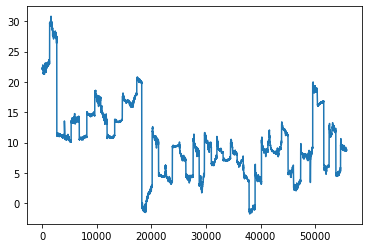

In [28]:
plt.plot(Fin['Temp'])